#### Import

In [1]:
import os
import sys
os.getcwd()  # Check current working directory
os.chdir('/home/sayem/Desktop/ImageCaption/notebooks')  # Change if necessary
sys.path.append('../src')  # Now append the src path

In [2]:
# import sys
# # Add the src directory to the Python path
# sys.path.append('../src')
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

import pandas as pd
# Set the maximum number of rows to 100 (default is 10 in newer versions)
pd.set_option('display.max_rows', 500)
# Set the maximum number of columns to 50 (default is 20)
pd.set_option('display.max_columns', 1500)

coco_data_folder = Path("/media/sayem/510B93E12554BBD1/CocoData")

# Define your device as either 'cuda' for GPU or 'cpu' for CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Dataset Building

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader
from dataset.dataset import CocoCaptionsDataset, collate_fn, Vocabulary

# # Image transformations
# transform = transforms.Compose([
#     transforms.Resize(256),  # Resize the image to a larger size while maintaining aspect ratio
#     transforms.CenterCrop(224),  # Center crop the image to 224x224
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, \
#         saturation=0.1, hue=0.1),  # Random color adjustments
#     transforms.ToTensor(),  # Convert the image to a PyTorch tensor
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize with mean and std for pretrained models
# ])

transform = transforms.Compose([
    transforms.Resize(256),  # Resize the image
    transforms.CenterCrop(224),  # Center crop the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=90),  # Rotate the image by up to ±30 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color adjustments
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize for pretrained models
])

In [4]:
import pickle
from pathlib import Path
from collections import Counter
from pycocotools.coco import COCO
import nltk
from nltk.tokenize import word_tokenize

import nltk
from pathlib import Path

# Set the NLTK data directory and download 'punkt' tokenizer model
nltk_data_path = Path("/home/sayem/Desktop/ImageCaption/nltk_data")
nltk_data_path.mkdir(parents=True, exist_ok=True)
nltk.data.path.append(str(nltk_data_path))
nltk.download('punkt', download_dir=str(nltk_data_path))
nltk.download('averaged_perceptron_tagger', download_dir=str(nltk_data_path))


# # Download the 'punkt' tokenizer models
# nltk.download('punkt', download_dir=nltk_data_path)

def build_vocab(json_file, threshold=5):
    coco = COCO(json_file)
    counter = Counter()

    for i, id in enumerate(coco.anns.keys()):
        caption = str(coco.anns[id]['caption']).lower()
        tokens = word_tokenize(caption)
        counter.update(tokens)

    vocab = Vocabulary()

    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    return vocab

# Paths
coco_data_folder = Path("/media/sayem/510B93E12554BBD1/CocoData")
annotations_file = coco_data_folder / 'annotations' / 'captions_train2017.json'

data_folder = Path('/home/sayem/Desktop/ImageCaption/data')
data_folder.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
vocab_file = data_folder / 'vocabulary.pkl'

# Check if vocabulary file exists
if not vocab_file.exists():
    # Build the vocabulary from the annotations file
    vocab = build_vocab(str(annotations_file))
    
    # Save the vocabulary
    try:
        with vocab_file.open('wb') as f:
            pickle.dump(vocab, f)
        print("Saved vocabulary to file.")
    except FileNotFoundError as e:
        print(f"Error saving file: {e}")
else:
    # Load the existing vocabulary
    try:
        with vocab_file.open('rb') as f:
            vocab = pickle.load(f)
        print("Loaded vocabulary from file.")
    except FileNotFoundError as e:
        print(f"Error loading file: {e}")

Loaded vocabulary from file.


[nltk_data] Downloading package punkt to
[nltk_data]     /home/sayem/Desktop/ImageCaption/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sayem/Desktop/ImageCaption/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Correct way to join paths using pathlib
train_dataset = CocoCaptionsDataset(
    root_dir=coco_data_folder / 'train2017',
    ann_file=coco_data_folder / 'annotations' / 'captions_train2017.json',
    vocab=vocab,
    transform=transform
)

# Rest of your code remains the same
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=10  # Adjust this number based on your system's capabilities
)

# Create the validation dataset
val_dataset = CocoCaptionsDataset(
    root_dir=coco_data_folder / 'val2017',  # Path to validation images
    ann_file=coco_data_folder / 'annotations' / 'captions_val2017.json',  # Path to validation annotations
    vocab=vocab,  # Vocabulary instance
    transform=transform  # Image transformations
)

# Create the DataLoader for the validation dataset
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=32,  # You can adjust the batch size if needed
    shuffle=False,  # Usually, we don't need to shuffle the validation data
    collate_fn=collate_fn,  # Use the same collate function as for the training dataset
    num_workers=10
)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
# # Correct way to join paths using pathlib
# train_dataset = CocoCaptionsDataset(
#     root_dir=coco_data_folder / 'train2017',
#     ann_file=coco_data_folder / 'annotations' / 'captions_train2017.json',
#     vocab=vocab,
#     transform=transform
# )

# from torch.utils.data import Subset
# import numpy as np

# # Assuming train_dataset is already created with CocoCaptionsDataset
# total_samples = len(train_dataset)  # Total number of samples in the dataset
# subset_size = 10000  # Number of samples you want in the subset

# # Randomly select 10,000 indices from the dataset
# subset_indices = np.random.choice(total_samples, subset_size, replace=False)

# # Create a subset dataset with these indices
# subset_train_dataset = Subset(train_dataset, subset_indices)

# # Use this subset for your DataLoader
# train_loader = DataLoader(
#     subset_train_dataset, 
#     batch_size=32, 
#     shuffle=True, 
#     collate_fn=collate_fn,
#     num_workers=2  # Adjust this number based on your system's capabilities
# )

# # Create the validation dataset
# val_dataset = CocoCaptionsDataset(
#     root_dir=coco_data_folder / 'val2017',  # Path to validation images
#     ann_file=coco_data_folder / 'annotations' / 'captions_val2017.json',  # Path to validation annotations
#     vocab=vocab,  # Vocabulary instance
#     transform=transform  # Image transformations
# )


# # Assuming train_dataset is already created with CocoCaptionsDataset
# total_samples = len(val_dataset)  # Total number of samples in the dataset
# subset_size = 10000  # Number of samples you want in the subset

# # Randomly select 10,000 indices from the dataset
# subset_indices = np.random.choice(total_samples, subset_size, replace=False)

# # Create a subset dataset with these indices
# subset_val_dataset = Subset(val_dataset, subset_indices)

# # Use this subset for your DataLoader
# # Create the DataLoader for the validation dataset
# val_loader = DataLoader(
#     dataset=subset_val_dataset, 
#     batch_size=32,  # You can adjust the batch size if needed
#     shuffle=False,  # Usually, we don't need to shuffle the validation data
#     collate_fn=collate_fn,  # Use the same collate function as for the training dataset
#     num_workers=2
# )

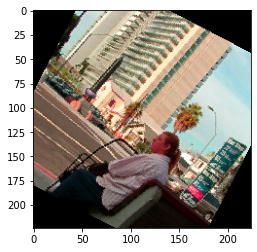

In [7]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import DataLoader

# Assuming val_loader is already defined

# Function to convert a tensor to an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()  # Use plt.show() to display the image

# Get a batch of data
images, _, _, _ = next(iter(val_loader))

# Select one image from the batch
img = images[0]  # Select the first image in the batch

# Display the image
imshow(img)


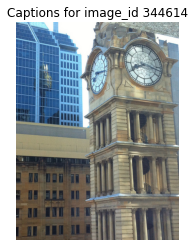

Caption 1: A clock town sits in the middle of a city.
Caption 2: A very tall clock tower sitting next to other tall buildings.
Caption 3: A large old building with a two clocks at the top.
Caption 4: a large building that has a clock tower
Caption 5: A clock tower with multiple columns in a city.


In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from pycocotools.coco import COCO


# Get all captions for a specific image ID
image_id = 344614 # Replace with an actual image ID
captions = val_dataset.get_all_captions_for_image(image_id)
image_path = val_dataset.get_image_path(image_id)

# Load the image
image = Image.open(image_path)

# Plotting
plt.imshow(image)
plt.axis('off')
plt.title(f"Captions for image_id {image_id}")
plt.show()

# Print the captions
for i, caption in enumerate(captions, 1):
    print(f"Caption {i}: {caption}")


In [9]:
img, caption, length, image_id = next(iter(train_loader))

print(img.shape)
print(caption.shape)
print(length.shape)
print(image_id.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32])
torch.Size([32])


#### Log

In [10]:
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

# Specify your custom directory for TensorBoard logs
log_dir = Path("/home/sayem/Desktop/ImageCaption/log_dir")

# Create the directory if it does not exist
log_dir.mkdir(parents=True, exist_ok=True)

# Create a TensorBoardLogger instance with the specified log directory
logger = TensorBoardLogger(save_dir=log_dir, name="_ImageCaptioningGCNN_LSTM")

#### Train

In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from trainer.trainer import ImageCaptioningModel

from models.decoders import DecoderLSTM

from models.encoders import ModifiedEncoderCNN, EncoderCNN
from models.group_cnn_layer import GroupConvLayer, GroupConvLayerWithAttention


# Define your parameters
embedding_size = 256
hidden_size = 512
vocab_size = len(vocab)  # Ensure 'vocab' is defined
num_layers = 2
max_seq_len = 20

group_elements = [0, 90, 180, 270]  # Example group elements

group_conv_layer = GroupConvLayer(
            in_channels=3, out_channels=64,
            kernel_size=7, group=group_elements,
            learnable_rotations=True)

# Instantiate encoder and decoder
encoder = ModifiedEncoderCNN(embedding_size, group_conv_layer)
decoder = DecoderLSTM(embedding_size, hidden_size, \
                    vocab_size, num_layers, max_seq_len)

# EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

# Instantiate the ImageCaptioningModel with encoder and decoder
model = ImageCaptioningModel(
    encoder=encoder,
    decoder=decoder,
    vocab=vocab, 
    val_dataset=val_dataset,  # Ensure 'val_dataset' is defined
    optimizer_name='adam', 
    scheduler_name='plateau',
    optimizer_params={'lr': 0.001},
    scheduler_params={'mode': 'min', 'factor': 0.1, 'patience': 5}
)

# Assuming 'logger' is defined and 'train_loader' and 'val_loader' are available
trainer = Trainer(logger=logger, max_epochs=15, callbacks=[early_stop_callback])

# Start training
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ModifiedEncoderCNN | 58.7 M
1 | decoder | DecoderLSTM        | 11.6 M
-----------------------------------------------
12.2 M    Trainable params
58.1 M    Non-trainable params
70.3 M    Total params
281.140   Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.98it/s]
--- Validation Metrics (Epoch Level) ---
val_loss_epoch: 9.2478
val_bleu_score: 0.0000
val_syntactic_errors: 0.0000
val_repetitions: 32.0000
val_diversity_score: 0.1772
Epoch 0: 100%|██████████| 18493/18493 [3:21:41<00:00,  1.53it/s, v_num=4, train_loss_step=1.570]  
--- Validation Metrics (Epoch Level) ---
val_loss_epoch: 1.6113
val_bleu_score: 0.0197
val_syntactic_errors: 0.0038
val_repetitions: 23.7486
val_diversity_score: 0.2197
Epoch 0: 100%|██████████| 18493/18493 [3:30:43<00:00,  1.46it/s, v_num=4, train_loss_step=1.570, val_loss_step=1.670, val_loss_epoch=1.610, train_loss_epoch=2.370]
--- Training Metrics ---
train_loss_step: 1.5672
train_loss_epoch: 2.3741
Epoch 1: 100%|██████████| 18493/18493 [3:24:19<00:00,  1.51it/s, v_num=4, train_loss_step=2.240, val_loss_step=1.670, val_loss_epoch=1.610, train_loss_epoch=2.370]  
--- Validation Metrics (Epoch Level) ---
val_loss_epoch: 1.5722
val_bleu_score: 0.0

In [12]:
# Define the directory and file path for saving the model
model_save_dir = Path("/home/sayem/Desktop/ImageCaption/trained_models")
model_save_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it does not exist
model_path = model_save_dir / "complete_image_captioning_model_GCNN_LSTM.pth"

# Save the entire model
torch.save(model, model_path)

print(f"Complete model saved at {model_path}")

Complete model saved at /home/sayem/Desktop/ImageCaption/trained_models/complete_image_captioning_model_GCNN_LSTM.pth


#### Testing

In [13]:
import torch
from pathlib import Path

# Define the path where the model is saved
model_path = Path("/home/sayem/Desktop/ImageCaption/trained_models/complete_image_captioning_model_GCNN_LSTM.pth")

# Check if the model file exists
if model_path.is_file():
    # Load the entire model
    model = torch.load(model_path)
    print("Model loaded successfully.")

    # Move the model to the appropriate device (if using GPU)
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the model to evaluation mode
    model.eval()

    # Now you can use the model for inference
    # Example: model(input_tensor)
else:
    print(f"Model file not found at {model_path}")

# [Rest of your code for using the model]

Model loaded successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption for Original Image:


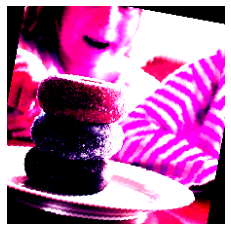

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a plate of food with a sandwich and a pickle . <end>

Caption for 90 Degree Rotated Image:


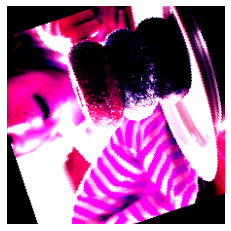

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a plate of food with a sandwich and a pickle . <end>

Caption for 270 Degree Rotated Image:


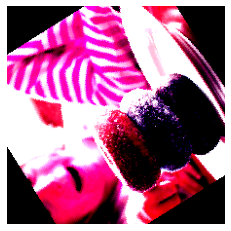

<start> a plate of food with a sandwich and a pickle . <end>

Semantic Consistency Score: 1.0


In [16]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Assuming 'transform', 'model', 'vocab', and 'device' are already defined and initialized

# Directory containing test images
coco_data_folder = Path("/media/sayem/510B93E12554BBD1/CocoData")
test_images_dir = coco_data_folder / 'test2017'

# List all image files in the directory
test_image_files = [f for f in test_images_dir.iterdir() if f.is_file()]

# Select a random image file
random_image_file = random.choice(test_image_files)

# Define the image loading function with rotation
def load_image(image_path, transform, rotate=False, rotation_angle=0):
    image = Image.open(image_path).convert('RGB')
    
    # Rotate the image if needed
    if rotate:
        image = image.rotate(rotation_angle)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

# Function to preprocess and tokenize caption
def process_caption(caption):
    # Convert to lowercase and tokenize
    tokens = word_tokenize(caption.lower())
    # Filter out punctuation and special characters
    words = [word for word in tokens if word.isalpha()]
    return words

# Function to calculate semantic consistency
def calculate_semantic_consistency(captions):
    # Process and tokenize all captions
    processed_captions = [process_caption(caption) for caption in captions]

    # Calculate intersection of words across all captions
    common_elements = set.intersection(*map(set, processed_captions))
    total_elements = set.union(*map(set, processed_captions))

    # Calculate consistency score (ratio of common elements to total unique elements)
    consistency_score = len(common_elements) / len(total_elements) if total_elements else 0
    return consistency_score

# Captions for each orientation
captions = []

# Function to display image and generate caption, and append caption to list
def display_and_caption(image, model, vocab, device):
    image_tensor = image.to(device)
    plt.imshow(image.squeeze(0).permute(1, 2, 0))  # Adjust dimensions for display
    plt.axis('off')
    plt.show()

    # Generate caption for the image
    with torch.no_grad():
        features = model.encoder(image_tensor)
        sampled_ids = model.decoder.sample(features)
        sampled_ids = sampled_ids[0].cpu().numpy()  # Convert to numpy array

    # Convert word_ids to words
    caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        caption.append(word)
        if word == '<end>':
            break
    caption = ' '.join(caption)
    captions.append(caption)

    # Print out the generated caption
    print(caption)

# Load and process images with different orientations
original_image = load_image(random_image_file, transform, rotate=False)
rotated_90_image = load_image(random_image_file, transform, rotate=True, rotation_angle=90)
rotated_270_image = load_image(random_image_file, transform, rotate=True, rotation_angle=270)

# Display images and generate captions
print("Caption for Original Image:")
display_and_caption(original_image, model, vocab, device)

print("\nCaption for 90 Degree Rotated Image:")
display_and_caption(rotated_90_image, model, vocab, device)

print("\nCaption for 270 Degree Rotated Image:")
display_and_caption(rotated_270_image, model, vocab, device)

# Calculate and print the semantic consistency score
consistency_score = calculate_semantic_consistency(captions)
print("\nSemantic Consistency Score:", consistency_score)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


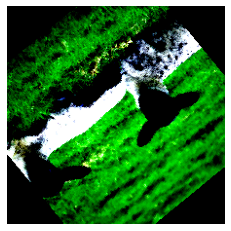

<start> a dog is running with a frisbee in its mouth . <end>


In [14]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Assuming 'transform' is already defined
# Assuming 'model', 'vocab', and 'device' are already defined and initialized

# Directory containing test images
coco_data_folder = Path("/media/sayem/510B93E12554BBD1/CocoData")
test_images_dir = coco_data_folder / 'test2017'

# List all image files in the directory
test_image_files = [f for f in test_images_dir.iterdir() if f.is_file()]

# Select a random image file
random_image_file = random.choice(test_image_files)

# Define the image loading function with rotation and flipping
def load_image(image_path, transform, rotate=False, rotation_angle=90, flip=True):
    image = Image.open(image_path).convert('RGB')
    
    # Rotate the image if needed
    if rotate:
        image = image.rotate(rotation_angle)

    # Flip the image if needed
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

# Load the image with desired transformations
transformed_image = load_image(random_image_file, transform, rotate=True, flip=False)
transformed_image_tensor = transformed_image.to(device)

# Display the transformed image
plt.imshow(transformed_image.squeeze(0).permute(1, 2, 0))  # Adjust dimensions for display
plt.axis('off')
plt.show()

# Generate caption for the transformed image
with torch.no_grad():
    features = model.encoder(transformed_image_tensor)
    sampled_ids = model.decoder.sample(features)
    sampled_ids = sampled_ids[0].cpu().numpy()  # Convert to numpy array

# Convert word_ids to words
caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    caption.append(word)
    if word == '<end>':
        break
caption = ' '.join(caption)

# Print out the generated caption
print(caption)